<a href="https://colab.research.google.com/github/Ann-Helen/machinelearning_masterthesis/blob/master/CNN_multifeature_onestep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# FILE MANAGEMENT (get .csv from drive)
# GENERAL
import numpy as np
from numpy import hstack, array
from numpy import asarray
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, describe

# KERAS
%tensorflow_version 1.x  # Fixes deprecation warnings
from keras.utils import plot_model  # Converts a Keras model to dot format and save to a file
# from keras.models import Model
# from keras.layers import Input    # used to instantiate a Keras tensor
from keras.layers import Dense    # Create layers
from keras.layers import Flatten  # Flattens tensor to vector
from keras.layers.convolutional import Conv1D # D convolution
from keras.layers.convolutional import MaxPooling1D # Max pooling operation for X data
from keras.layers import Dropout
# from keras.layers.merge import concatenate
from keras.models import Sequential
from keras.callbacks import EarlyStopping, TerminateOnNaN

from sklearn import preprocessing
#from sklearn.preprocessing import MinMaxScaler

# Fix for the 'Run after'-bug caused by Colab
CLEAN_RUN = True

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # Fixes deprecation warnings`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


              Open         High          Low        Close
count  2317.000000  2317.000000  2317.000000  2317.000000
mean      0.240468     0.242753     0.244632     0.243797
std       0.230394     0.233074     0.232988     0.233023
min       0.003939     0.004122     0.005619     0.004195
25%       0.055562     0.056040     0.057225     0.056793
50%       0.148544     0.149898     0.151948     0.150884
75%       0.377238     0.380989     0.383352     0.382280
max       1.000000     1.000000     1.000000     1.000000 

            Volume        50SMA       200SMA
count  2317.000000  2317.000000  2317.000000
mean      0.113906     0.232104     0.206899
std       0.079666     0.222600     0.197977
min       0.000000     0.010719     0.015547
25%       0.061620     0.052079     0.041716
50%       0.094080     0.141146     0.133130
75%       0.147315     0.361818     0.304570
max       1.000000     0.872307     0.763745 

plotting Open...
plotting High...
plotting Low...
plotting Close...
p

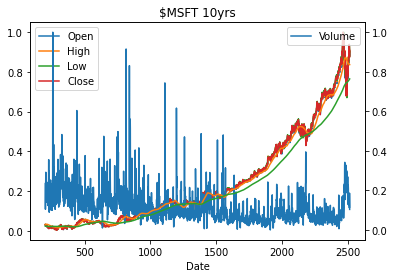

In [ ]:
# IMPORT & NORMALIZE DATA
URL = 'https://raw.githubusercontent.com/victordahl/dataset/master/MSFT_10yrs.csv'
#URL = 'https://raw.githubusercontent.com/victordahl/dataset/master/MSFT_10yrs_open.csv'
csvfile = pd.read_csv(URL)
#print("cvs type", type(csvfile))

#print(csvfile.iloc[:, 1:]) 
min_max_scaler = preprocessing.MinMaxScaler()

# Normalize last five columns (excluding date in first columns)
x_scaled = min_max_scaler.fit_transform(csvfile.iloc[:, 1:])
df = pd.DataFrame(x_scaled)
# Rename all columns
df.columns = ["Open","High","Low","Close","Volume"]

# Derived features
short_SMA = 50
long_SMA = 200
df["50SMA"] = df["Open"].rolling(window=short_SMA).mean()
df["200SMA"] = df["Open"].rolling(window=long_SMA).mean()
# Trim head of dataset to remove the NaN days in SMA feature head
df = df.iloc[long_SMA:len(df)]

# describe and visualize data
print(df.iloc[:, 0:4].describe(),"\n")
print(df.iloc[:, 4:].describe(),"\n")

#tail = int(input("Print tail:"))
tail=2517
fig, ax1 = plt.subplots()
plt.title("$MSFT 10yrs")
plt.xlabel("Date")

df_columns = []
for i in df.columns:
  if i != "Volume":
    print("plotting {}...".format(i))
    plt.plot(df[i].tail(tail), label=i)
    ax1.legend(loc=2)
  elif i == "Volume":
    # Put 'Volume' on second Y axis for better plot
    print("plotting {}...".format(i))
    ax2 = ax1.twinx()
    ax2.plot(df[i].tail(tail), label=i)
    ax2.legend(loc=1)


In [ ]:
# DATASET
SET_SIZE = 2000
raw_train_set = df.iloc[0:SET_SIZE]
raw_test_set = df.iloc[SET_SIZE:len(df)]
assert(len(raw_train_set)==SET_SIZE), "Something wrong with dataset separation..."

In [ ]:
def split_seq(sequences, NUM_STEPS, return_y=False):
  """ Split a multivariate sequence into samples. 
  sequences(array): one feature
  NUM_STEPS (int): number of steps/days in input
  return_y (bool=False): When true returns only Y, default False returns only X

  OUTPUT: X OR y (array): feature with steps
  """
  X, y = list(), list()
  for i in range(len(sequences)):
		# find the end of this pattern
    end_ix = i + NUM_STEPS
    # check if we are beyond the dataset
    if end_ix > len(sequences):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, -1]
    X.append(seq_x)
    y.append(seq_y)
  if return_y:  # Y value for feature to be predicted
    return array(y)
  elif not return_y: # X value for all features
    return array(X)


In [ ]:
def generate_features_n(NUM_STEPS, feat):
  """ Generate features for multivariate data
  Args: features (Dataframe): Contains N number of features
  Output: X, y (np.array): X (input) and y (output) sequences
  """

  # DEFINE individual input sequence as array
  open_seq = array(feat["Open"])
  high_seq = array(feat["High"])
  low_seq = array(feat["Low"])
  close_seq = array(feat["Close"])
  vol_seq = array(feat["Volume"])
  ssma_seq = array(feat["50SMA"])
  lsma_seq = array(feat["200SMA"])
  
  # RESHAPE to colums
  open_seq = open_seq.reshape((len(open_seq), 1))
  high_seq = high_seq.reshape((len(high_seq), 1))
  low_seq = low_seq.reshape((len(low_seq), 1))
  close_seq = close_seq.reshape((len(close_seq), 1))
  vol_seq = vol_seq.reshape((len(vol_seq), 1))
  ssma_seq = ssma_seq.reshape((len(ssma_seq), 1))
  lsma_seq = lsma_seq.reshape((len(lsma_seq), 1))

  # HORISONTALLY STACK columns
  dataset = hstack((open_seq, high_seq, low_seq, close_seq, vol_seq, ssma_seq, lsma_seq))

  # SPLIT SEQUENCES
  X = split_seq(dataset, NUM_STEPS)
  y = split_seq(close_seq, NUM_STEPS, return_y=True)
  return X, y


In [ ]:
# FEATURE GEN
NUM_STEPS =  90

# TRAINING SET
train_set_X, train_set_y = generate_features_n(NUM_STEPS, raw_train_set)

# PREDICTION SET
test_set_X, test_set_y = generate_features_n(NUM_STEPS, raw_test_set )

# Assert that there are no NaN values
assert(not np.isnan(np.sum(train_set_X))), "NaN values found in input!"
assert(not np.isnan(np.sum(train_set_y))), "NaN values found in input!"
assert(not np.isnan(np.sum(test_set_X))), "NaN values found in input!"


train shape (1911, 90, 7)
######################
features 7
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 88, 32)            704       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 29, 32)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 928)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 15)                13935     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 16        
Total params: 14,655
Trainable params: 14,655
Non-trainable params: 0
_________________________________________________________________
None


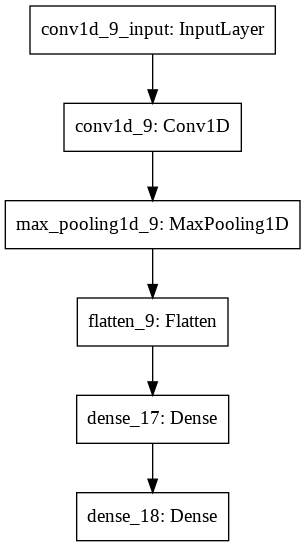

In [ ]:
# MODEL
NUM_FILTERS = 32 #10            # <---------- TUNE ME
KERNEL_SIZE = 3 #2             # <---------- TUNE ME
UNITS_PER_DENSE_LAYER = 15 #10 # this should be AT LEAST 10 and LESS THAN 16! ) <---------- TUNE ME
# Features of train_set_X as shape =(samples, steps, features)

print("train shape", train_set_X.shape)
n_features = train_set_X.shape[2] # Must be '2'! Otherwise incorrect format of train_set_X

print("######################")
print("features", n_features)

# ------------------------------------------------------------------------------------------------------------------- CONV 1
model = Sequential()
model.add(Conv1D(
    filters = NUM_FILTERS, 
    kernel_size = KERNEL_SIZE,
    activation = 'sigmoid', 
    input_shape = (NUM_STEPS, n_features) # batch_input_shape?
  )
)
model.add(MaxPooling1D(pool_size=3)) # <-------------- Decrease before next convid layer?

# IF MORE THAN 1 Conv1D layer add DROPOUT LAYER

"""model.add(Dropout(0.5)) #<---------------------------------------------------------------------------------------Add later"""

# ------------------------------------------------------------------------------------------------------------------- CONV 2
"""model.add(Conv1D(
    filters = 150, 
    kernel_size = 15, 
    activation = 'sigmoid', 
    input_shape = (NUM_STEPS, n_features) # batch_input_shape?
  )
)

model.add(MaxPooling1D(pool_size=6)) """

"""# ------------------------------------------------------------------------------------------------------------------- CONV 3
model.add(Conv1D(
    filters = 300, 
    kernel_size = 2, 
    activation = 'sigmoid', 
    input_shape = (NUM_STEPS, n_features) # batch_input_shape?
  )
)

model.add(MaxPooling1D(pool_size=2)) """

# add conv
# add Maxpool

# add conv
# add Maxpool

model.add(Flatten())
model.add(Dense(UNITS_PER_DENSE_LAYER, activation = 'sigmoid'))
model.add(Dense(1))

"""
look for CNN Time series prediction, not nec. stock m. prediction
more layers = more params = model needs more data
"""

model.compile(
  optimizer = 'adam',
  loss = 'mse', 
  metrics = ['accuracy','mean_squared_error']
)
print(model.summary())
plot_model(model)

7
Train on 1528 samples, validate on 383 samples
Epoch 1/150
1528/1528 [==============================] - 1s 478us/step - loss: 0.0300 - accuracy: 0.0000e+00 - mean_squared_error: 0.0300 - val_loss: 0.0537 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0537
Epoch 2/150
1528/1528 [==============================] - 0s 269us/step - loss: 0.0018 - accuracy: 0.0000e+00 - mean_squared_error: 0.0018 - val_loss: 0.0142 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0142
Epoch 3/150
1528/1528 [==============================] - 0s 268us/step - loss: 3.9608e-04 - accuracy: 0.0000e+00 - mean_squared_error: 3.9608e-04 - val_loss: 0.0020 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0020
Epoch 4/150
1528/1528 [==============================] - 0s 271us/step - loss: 2.9545e-04 - accuracy: 0.0000e+00 - mean_squared_error: 2.9545e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011
Epoch 5/150
1528/1528 [==============================] - 0s 275us/s

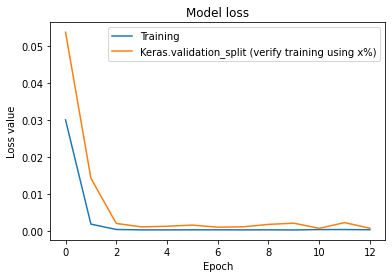

In [ ]:
# TRAIN
callbacks = [
  EarlyStopping(
    # Stop training when `val_loss` is no longer improving
    monitor='val_loss',
    # "no longer improving" being defined as "no better than 1e-2 less"
    min_delta=1e-2,
    # "no longer improving" defined as "for at least 2 epochs"
    patience=10,
    verbose=1
    #restore_best_weights = True  # This only seems to make it worse!
  ),
  TerminateOnNaN() # Stops training if loss = NaN
  ]


print(n_features)
if CLEAN_RUN:
  # Only allows training if training has not been run
  history = model.fit(
    train_set_X.reshape((len(train_set_X), NUM_STEPS, n_features)), 
    train_set_y,
    validation_split = 0.2,
    epochs = 150,     #150 <---------- TUNE ME (early stop callback)
    batch_size = 16,  #16 <---------- TUNE ME
    verbose = 1,
    callbacks = callbacks
  )
  CLEAN_RUN = False # Prevents double-training
elif not CLEAN_RUN:
  print("Session is not CLEAN_RUN. Use Colab 'Run all'!")

print("\n___MODEL LOSS___")
print("Final MSE:   ", history.history['mean_squared_error'][-1])
plt.plot(history.history['mean_squared_error']) #previously 'loss'
plt.plot(history.history['val_mean_squared_error']) #previously 'val_loss'
plt.title('Model loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(['Training', 'Keras.validation_split (verify training using x%)'], loc='best')
plt.show()

In [ ]:
# Predict
print("Making prediction...")

x_input = test_set_X#.reshape((1, NUM_STEPS, n_features))
prediction = model.predict(x_input, verbose=1)

#print(type(prediction))
#print("Pred. shape:", prediction.shape) # (228, 1)
assert(type(prediction) == type(array([]))) # Prediction should be np.array

tail = df.iloc[:, :-6].tail(len(prediction))
tail = tail.to_numpy()
#print("TAIL:\n", tail)
assert(tail.shape == prediction.shape)
#nrm_scale_df = array(tail).reshape(-1, 1) 

# Reset scaler to accepting the shape (228, 1)
set_new_scaled = min_max_scaler.fit_transform(csvfile.iloc[:, [1]])

# Denormalize
prediction = min_max_scaler.inverse_transform(prediction)
historic = min_max_scaler.inverse_transform(tail)
#print("historic", historic)

compare_df = pd.DataFrame({
    'Prediction': prediction[0],
    'Historic': historic[0]
    })
print(compare_df, "\nSimilarity:",round(*(prediction[0]/historic[0])*100,2),"%")
#print("\nPrediction:")
#print(prediction)

print("\nShapes match:", prediction.flatten().shape==historic.flatten().shape)
#print(prediction.reshape(len(prediction)).shape)
print("Prediction shape:", prediction.flatten().shape)
print("Historic data shape:", historic.flatten().shape)

Making prediction...
228/228 [==============================] - 0s 1ms/step
   Prediction  Historic
0  118.415596    125.38 
Similarity: 94.45 %

Shapes match: True
Prediction shape: (228,)
Historic data shape: (228,)


___Short view___
Historic: (228, 1)
Prediction: (228, 1)
Pearson R: 0.79



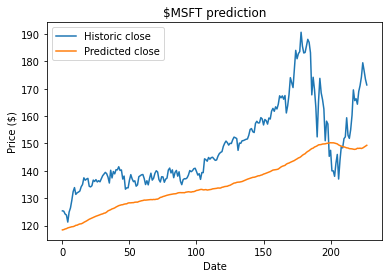

In [ ]:
# Plot
print("___Short view___")
print("Historic:", historic.shape)
print("Prediction:", prediction.shape)

# print(historic.describe())

# Data to be plotted
plt.plot(historic, label='Historic close')
plt.plot(prediction, label='Predicted close')
plt.draw()

plt.title("$MSFT prediction")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()

plt.draw()

pr = pearsonr(historic.flatten(), prediction.flatten())[0]
print("Pearson R:", round(pr,2))
print("")
# print(compare_df.describe())